# GitHub Link

https://github.com/zonggen/csc598lho-project

# Prepara Data

In [1]:
!rm -rf event.db && wget https://raw.githubusercontent.com/YifanDengWHU/DDIMDL/master/event.db
!ls -l

--2024-04-10 04:53:40--  https://raw.githubusercontent.com/YifanDengWHU/DDIMDL/master/event.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30580736 (29M) [application/octet-stream]
Saving to: ‘event.db’

event.db            100%[===================>]  29.16M   106MB/s    in 0.3s    

2024-04-10 04:53:41 (106 MB/s) - ‘event.db’ saved [30580736/30580736]

total 29868
-rw-r--r-- 1 root root 30580736 Apr 10 04:53 event.db
drwxr-xr-x 1 root root     4096 Apr  8 13:27 sample_data


# Introduction

The motivation behind the study lies in the critical need to predict drug-drug interactions (DDIs). DDIs occur when two or more drugs interact in a way that alters the effect of one or all of the drugs. These interactions can lead to unexpected side effects, reduce the effectiveness of the drugs, or increase the action of the drugs, which can be harmful or even deadly. The study aims to address these challenges by developing a deep learning framework that can accurately predict DDIs, contributing to safer and more effective treatment strategies. The ultimate goal is to improve patient outcomes and advance personalized medicine.

This study obtains the DDI data from DrugBank, and applies NLP techniques to classify DDI-associated events into 65 types according to their descriptions’ syntax, and compiles a dataset of 572 drugs, 74 528 interactions and 65 types of DDI-associated events. A multimodal deep learning framework named DDIMDL that combines diverse drug features with deep learning is presented for the DDI event prediction. Evaluated using 5-fold cross validations, DDIMDL outperforms the existing DDI event prediction method and baseline methods. The case studies are also performed to identify the DDI events not included in our dataset, and several DDI-associated events, such as the event caused by the interaction between Dextroamphetamine and Fenfluramine, are successfully found out.

A convolutional neural network based deep learning framework called DDIMDL is proposed, utilizing multiple drug features such as chemical substructures, targets, enzymes, and pathways to predict DDI events, using the DrugBank database:

![](https://raw.githubusercontent.com/YifanDengWHU/img/master/workFlow.bmp)

# Scope of Reproducibility:

I will evalutate and reproduce the model performance between the DNN model from the paper as well as other common classifier models, including RandomForestClassifier, GradientBoostingClassifier, SVM, GradientBoostintgClassifier, KNearestNeighborClassifier and LogisticRegression. The ablations are done through replacing the proposed DDIMDL model with other common classifiers.

1. Hypothesis 1: Performance measurement with DNN / DDIMDL
1. Hypothesis 2: Performance measurement with RF
1. Hypothesis 3: Performance measurement with GBDT
1. Hypothesis 4: Performance measurement with SVM
1. Hypothesis 5: Performance measurement with KNN
1. Hypothesis 6: Performance measurement with LogisticRegression


# Methodology

## Environment Setup

In [2]:
!pip install Keras numpy pandas scikit-learn tensorflow_decision_forests matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found exist

In [3]:
import matplotlib.pyplot as plt
import csv
import sqlite3
import time
import numpy as np
import pandas as pd
from pprint import pprint
from pandas import DataFrame
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

##  Data

The authors collected 3844 FDA approved drugs and 567 experimental drugs, their corresponding DDIs as well as four features of drugs: chemical substructures, targets, pathways and enzymes from DrugBank. Then StanfordNLP tool was used to construct the events: (drugA, drugB, mechanism, action), where the mechanism means the effect of drugs in terms of the metabolism, the serum concentration, the therapeutic efficacy and so on. The action represents the effectiveness change as the result of the DDI.

Source data can be found at: https://github.com/YifanDengWHU/DDIMDL/blob/master/event.db

In [4]:
event_num = 65
vector_size = 572
seed = 0

In [5]:
DATA_FILE="event.db"

conn = sqlite3.connect(DATA_FILE)
df_drug = pd.read_sql('select * from drug;', conn)
df_event = pd.read_sql('select * from event_number;', conn)
df_interaction = pd.read_sql('select * from event;', conn)

In [6]:
# Features to use
feature_list = ['smile', 'target', 'enzyme']

featureName="+".join(feature_list)
set_name = '+'.join(feature_list)
all_matrix = []
drugList=[]

extraction = pd.read_sql('select * from extraction;', conn)
mechanism = extraction['mechanism']
action = extraction['action']
drugA = extraction['drugA']
drugB = extraction['drugB']

In [7]:
df_drug

,index,id,target,enzyme,pathway,smile,name
0,0,DB01296,P14780|Q00653|P01375|P01579|P33673,P33261|P05181,hsa:4318|hsa:4791|hsa:7124|hsa:3458,9|10|14|18|19|20|178|181|283|284|285|286|299|3...,Glucosamine
1,1,DB09230,Q02641,P08684,hsa:782,9|10|11|12|13|14|15|16|18|19|20|129|131|132|17...,Azelnidipine
2,2,DB05812,P05093,P08684|Q06520|P10635|P10632|P05177|P33261|P11712,hsa:1586,9|10|11|12|14|18|143|147|178|179|182|183|184|1...,Abiraterone
3,3,DB01195,Q14524|P35499|Q12809,P10635|P11712,hsa:6331|hsa:6329|hsa:3757,9|10|11|12|14|15|18|19|23|24|25|178|180|181|18...,Flecainide
4,4,DB00201,P30542|P29274|Q07343|P21817|BE0004922|P78527|O...,P20815|P05177|P24462|P08684|P05181|P10632|P117...,hsa:134|hsa:135|hsa:5142|hsa:6261|hsa:5591|hsa...,9|10|11|14|15|16|18|19|143|148|149|178|183|184...,Caffeine
...,...,...,...,...,...,...,...
567,567,DB01587,P30536|P14867|P18505|Q8N1C3|O14764|P78334,P08684,hsa:706|hsa:2554|hsa:2560|hsa:2565|hsa:2563|hs...,9|10|11|12|14|15|18|19|37|178|182|183|184|185|...,Ketazolam
568,568,DB00448,P20648|P10636,P33261|P11712|P08684|P04798|P05177|Q16678|P332...,hsa:495|hsa:4137,9|10|11|12|14|15|18|19|23|24|33|143|148|149|17...,Lansoprazole
569,569,DB00559,P25101|P24530,P08684|P11712,hsa:1909|hsa:1910,9|10|11|12|14|15|16|18|19|20|33|178|182|183|18...,Bosentan
570,570,DB04953,O43526|O43525|P56696|Q9NR82,P22309|P35503|P22310|O60656|P11509|P11245,hsa:3785|hsa:3786|hsa:9132|hsa:56479,9|10|11|12|14|15|18|19|23|178|182|185|189|283|...,Ezogabine


In [8]:
df_event

,event,number
0,The metabolism of name can be decreased when c...,19620
1,The risk or severity of adverse effects can be...,18992
2,The serum concentration of name can be increas...,11292
3,The serum concentration of name can be decreas...,4772
4,The therapeutic efficacy of name can be decrea...,2624
...,...,...
60,The risk of a hypersensitivity reaction to nam...,10
61,name may increase the hyperglycemic activities...,10
62,name may increase the hypocalcemic activities ...,10
63,name may increase the myelosuppressive activit...,10


In [9]:
df_interaction

,index,id1,name1,id2,name2,interaction
0,0,DB12001,Abemaciclib,DB01118,Amiodarone,The risk or severity of adverse effects can be...
1,1,DB12001,Abemaciclib,DB11901,Apalutamide,The serum concentration of Abemaciclib can be ...
2,2,DB12001,Abemaciclib,DB00673,Aprepitant,The serum concentration of Abemaciclib can be ...
3,3,DB12001,Abemaciclib,DB00289,Atomoxetine,The metabolism of Abemaciclib can be decreased...
4,4,DB12001,Abemaciclib,DB00188,Bortezomib,The metabolism of Abemaciclib can be decreased...
...,...,...,...,...,...,...
37259,37259,DB01149,Nefazodone,DB09048,Netupitant,The serum concentration of Nefazodone can be i...
37260,37260,DB01149,Nefazodone,DB00622,Nicardipine,The metabolism of Nefazodone can be decreased ...
37261,37261,DB11828,Neratinib,DB09048,Netupitant,The serum concentration of Neratinib can be in...
37262,37262,DB09048,Netupitant,DB00622,Nicardipine,The serum concentration of Netupitant can be i...


In [10]:
extraction

,index,mechanism,action,drugA,drugB
0,0,The risk or severity of adverse effects,increase,Abemaciclib,Amiodarone
1,1,The serum concentration,decrease,Abemaciclib,Apalutamide
2,2,The serum concentration,increase,Abemaciclib,Aprepitant
3,3,The metabolism,decrease,Abemaciclib,Atomoxetine
4,4,The metabolism,decrease,Abemaciclib,Bortezomib
...,...,...,...,...,...
37259,37259,The serum concentration,increase,Nefazodone,Netupitant
37260,37260,The metabolism,decrease,Nefazodone,Nicardipine
37261,37261,The serum concentration,increase,Neratinib,Netupitant
37262,37262,The serum concentration,increase,Netupitant,Nicardipine


In [11]:
def prepare(df_drug, feature_list, vector_size,mechanism,action,drugA,drugB):
    d_label = {}
    d_feature = {}
    # Transfrom the interaction event to number
    # Splice the features
    d_event=[]
    for i in range(len(mechanism)):
        d_event.append(mechanism[i]+" "+action[i])
    label_value = 0
    count={}
    for i in d_event:
        if i in count:
            count[i]+=1
        else:
            count[i]=1
    list1 = sorted(count.items(), key=lambda x: x[1],reverse=True)
    for i in range(len(list1)):
        d_label[list1[i][0]]=i
    vector = np.zeros((len(np.array(df_drug['name']).tolist()), 0), dtype=float)
    for i in feature_list:
        vector = np.hstack((vector, feature_vector(i, df_drug, vector_size)))
    # Transfrom the drug ID to feature vector
    for i in range(len(np.array(df_drug['name']).tolist())):
        d_feature[np.array(df_drug['name']).tolist()[i]] = vector[i]
    # Use the dictionary to obtain feature vector and label
    new_feature = []
    new_label = []
    name_to_id = {}
    for i in range(len(d_event)):
        new_feature.append(np.hstack((d_feature[drugA[i]], d_feature[drugB[i]])))
        new_label.append(d_label[d_event[i]])
    new_feature = np.array(new_feature)
    new_label = np.array(new_label)
    return (new_feature, new_label, event_num)

def feature_vector(feature_name, df, vector_size):
    # df are the 572 kinds of drugs
    # Jaccard Similarity
    def Jaccard(matrix):
        matrix = np.mat(matrix)
        numerator = matrix * matrix.T
        denominator = np.ones(np.shape(matrix)) * matrix.T + matrix * np.ones(np.shape(matrix.T)) - matrix * matrix.T
        return numerator / denominator

    all_feature = []
    drug_list = np.array(df[feature_name]).tolist()
    # Features for each drug, for example, when feature_name is target, drug_list=["P30556|P05412","P28223|P46098|……"]
    for i in drug_list:
        for each_feature in i.split('|'):
            if each_feature not in all_feature:
                all_feature.append(each_feature)  # obtain all the features
    feature_matrix = np.zeros((len(drug_list), len(all_feature)), dtype=float)
    df_feature = DataFrame(feature_matrix, columns=all_feature)  # Consrtuct feature matrices with key of dataframe
    for i in range(len(drug_list)):
        for each_feature in df[feature_name].iloc[i].split('|'):
            df_feature[each_feature].iloc[i] = 1
    sim_matrix = Jaccard(np.array(df_feature))

    sim_matrix1 = np.array(sim_matrix)
    count = 0
    pca = PCA(n_components=vector_size)  # PCA dimension
    pca.fit(np.asarray(sim_matrix))
    sim_matrix = pca.transform(np.asarray(sim_matrix))
    return sim_matrix

In [12]:
for feature in feature_list:
    pprint(f'feature feat={feature}')
    new_feature, new_label, event_num = prepare(df_drug, [feature], vector_size, mechanism,action,drugA,drugB)
    all_matrix.append(new_feature)
all_matrix

'feature feat=smile'
'feature feat=target'
'feature feat=enzyme'


[array([[-5.50822011e-01,  3.16967827e+00, -1.37253742e-01, ...,
         -5.55111512e-17, -1.38777878e-17, -7.28583860e-17],
        [-5.50822011e-01,  3.16967827e+00, -1.37253742e-01, ...,
         -4.85722573e-17, -4.16333634e-17,  1.04083409e-16],
        [-5.50822011e-01,  3.16967827e+00, -1.37253742e-01, ...,
         -6.93889390e-18, -4.59701721e-17, -4.16333634e-17],
        ...,
        [-1.09680344e+00,  1.38541285e+00, -1.38446925e+00, ...,
          2.77555756e-17, -2.60208521e-17,  1.82498331e-16],
        [-1.35282107e+00,  2.30799232e+00,  1.51359574e-01, ...,
         -4.85722573e-17,  2.42861287e-17, -6.93889390e-17],
        [-2.07144651e+00, -1.71437659e-01,  3.37111947e-01, ...,
         -5.55111512e-17,  0.00000000e+00, -1.23165367e-16]]),
 array([[-5.41580850e-02, -1.26844824e-01, -1.30110552e-01, ...,
          3.12250226e-17,  6.93889390e-17, -3.46944695e-18],
        [-5.41580850e-02, -1.26844824e-01, -1.30110552e-01, ...,
         -2.08166817e-17,  2.08166817e

##   Model

![](https://raw.githubusercontent.com/YifanDengWHU/img/master/workFlow.bmp)

| Layers           | Configuration                  | Activation Function | Output Dimension (batch, feature) |
|------------------|--------------------------------|---------------------|----------------------------------|
| Fully connected  | Input size: 1144, Output size: 512 | ReLU | (128, 512) |
| Batch Normalization | - | - | (128, 512) |
| Dropout          | Dropout rate: 0.3          | -                   | (128, 512)                       |
| Fully connected  | Input size: 512, Output size: 256 | ReLU | (128, 256) |
| Batch Normalization | - | - | (128, 256) |
| Dropout          | Dropout rate: 0.3          | -                   | (128, 256)                       |
| Fully connected  | Input size: 256, Output size: 65 | - | (128, 65) |
| Activation       | Softmax                         | -                   | (128, 65)                 |


In [13]:
droprate = 0.3

def DNN():
    train_input = Input(shape=(vector_size * 2,), name='Inputlayer')
    train_in = Dense(512, activation='relu')(train_input)
    train_in = BatchNormalization()(train_in)
    train_in = Dropout(droprate)(train_in)
    train_in = Dense(256, activation='relu')(train_in)
    train_in = BatchNormalization()(train_in)
    train_in = Dropout(droprate)(train_in)
    train_in = Dense(event_num)(train_in)
    out = Activation('softmax')(train_in)
    model = Model(train_input, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Results

## Computational requirements

The project notebook was written in a Colab notebook with CPU only environment. In additon, the local notebook was run on a 2.6 GHz 6-Core Intel Core i7 Macbook Pro. The main DNN model was relatively quick, averaging around 3mins for 3-fold, 3-feature, 3 epochs setting. No GPU was used.

## Training (DNN)

In this section, we use train the proposed DNN model from the original paper, and measure the performance for each fold, feature, and epoch. The measurement is plotted into k-fold number of rows, each row represents the corresponding performance for the fold. Each column contains the model performance trained with the corresponding feature. And finally, within each plot, the accuracy and losses over epochs are drawn.

In [14]:
epochs = 3
CV = 3 # Kfold

In [15]:
import tensorflow_decision_forests as tfdf
def get_index(label_matrix, event_num, seed, CV):
    index_all_class = np.zeros(len(label_matrix))
    for j in range(event_num):
        index = np.where(label_matrix == j)
        kf = KFold(n_splits=CV, shuffle=True, random_state=seed)
        k_num = 0
        for train_index, test_index in kf.split(range(len(index[0]))):
            index_all_class[index[0][test_index]] = k_num
            k_num += 1

    return index_all_class

def multiclass_precision_recall_curve(y_true, y_score):
    y_true = y_true.ravel()
    y_score = y_score.ravel()
    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))
    if y_score.ndim == 1:
        y_score = y_score.reshape((-1, 1))
    y_true_c = y_true.take([0], axis=1).ravel()
    y_score_c = y_score.take([0], axis=1).ravel()
    precision, recall, pr_thresholds = precision_recall_curve(y_true_c, y_score_c)
    return (precision, recall, pr_thresholds)

def roc_aupr_score(y_true, y_score, average="macro"):
    def _binary_roc_aupr_score(y_true, y_score):
        precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
        return auc(recall, precision)

    def _average_binary_score(binary_metric, y_true, y_score, average):  # y_true= y_one_hot
        if average == "binary":
            return binary_metric(y_true, y_score)
        if average == "micro":
            y_true = y_true.ravel()
            y_score = y_score.ravel()
        if y_true.ndim == 1:
            y_true = y_true.reshape((-1, 1))
        if y_score.ndim == 1:
            y_score = y_score.reshape((-1, 1))
        n_classes = y_score.shape[1]
        score = np.zeros((n_classes,))
        for c in range(n_classes):
            y_true_c = y_true.take([c], axis=1).ravel()
            y_score_c = y_score.take([c], axis=1).ravel()
            score[c] = binary_metric(y_true_c, y_score_c)
        return np.average(score)

    return _average_binary_score(_binary_roc_aupr_score, y_true, y_score, average)


def evaluate(pred_type, pred_score, y_test, event_num, set_name):
    # 11 metric types for overall metrics
    all_eval_type = 11
    # 6 metric types for per-event based metrics
    each_eval_type = 6

    result_all = DataFrame(columns=['Accuracy', 'AUPR_micro', 'AUPR_macro', 'AUROC_micro', 'AUROC_macro', 'F1_micro',
                                    'F1_macro', 'Precision_micro', 'Precision_macro', 'Recall_micro', 'Recall_macro'])
    result_eve = DataFrame(columns=['Event#', 'Accuracy', 'AUPR', 'AUROC', 'F1', 'Precision', 'Recall'])

    y_one_hot = label_binarize(y_test, classes=np.arange(event_num))
    pred_one_hot = label_binarize(pred_type, classes=np.arange(event_num))
    precision, recall, th = multiclass_precision_recall_curve(y_one_hot, pred_score)

    result_all.loc[0, 'Accuracy'] = accuracy_score(y_test, pred_type)
    result_all.loc[0, 'AUPR_micro'] = roc_aupr_score(y_one_hot, pred_score, average='micro')
    result_all.loc[0, 'AUPR_macro'] = roc_aupr_score(y_one_hot, pred_score, average='macro')
    result_all.loc[0, 'AUROC_micro'] = roc_auc_score(y_one_hot, pred_score, average='micro')
    result_all.loc[0, 'AUROC_macro'] = roc_auc_score(y_one_hot, pred_score, average='macro')
    result_all.loc[0, 'F1_micro'] = f1_score(y_test, pred_type, average='micro')
    result_all.loc[0, 'F1_macro'] = f1_score(y_test, pred_type, average='macro')
    result_all.loc[0, 'Precision_micro'] = precision_score(y_test, pred_type, average='micro')
    result_all.loc[0, 'Precision_macro'] = precision_score(y_test, pred_type, average='macro')
    result_all.loc[0, 'Recall_micro'] = recall_score(y_test, pred_type, average='micro')
    result_all.loc[0, 'Recall_macro'] = recall_score(y_test, pred_type, average='macro')

    for i in range(event_num):
        result_eve.loc[i, 'Event#'] = i
        result_eve.loc[i, 'Accuracy'] = accuracy_score(y_one_hot.take([i], axis=1).ravel(),
                                                       pred_one_hot.take([i], axis=1).ravel())
        result_eve.loc[i, 'AUPR'] = roc_aupr_score(y_one_hot.take([i], axis=1).ravel(),
                                                   pred_one_hot.take([i], axis=1).ravel(), average=None)
        result_eve.loc[i, 'AUROC'] = roc_auc_score(y_one_hot.take([i], axis=1).ravel(),
                                                  pred_one_hot.take([i], axis=1).ravel(), average=None)
        result_eve.loc[i, 'F1'] = f1_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(),
                                          average='binary')
        result_eve.loc[i, 'Precision'] = precision_score(y_one_hot.take([i], axis=1).ravel(),
                                                        pred_one_hot.take([i], axis=1).ravel(), average='binary')
        result_eve.loc[i, 'Recall'] = recall_score(y_one_hot.take([i], axis=1).ravel(),
                                                  pred_one_hot.take([i], axis=1).ravel(), average='binary')
    return [result_all, result_eve]

def cross_validation(feature_matrix, label_matrix, clf_type, event_num, seed, CV, set_name):
    all_eval_type = 11
    result_all = np.zeros((all_eval_type, 1), dtype=float)
    each_eval_type = 6
    result_eve = np.zeros((event_num, each_eval_type), dtype=float)
    y_true = np.array([])
    y_pred = np.array([])
    y_score = np.zeros((0, event_num), dtype=float)
    index_all_class = get_index(label_matrix, event_num, seed, CV)
    matrix = []
    if type(feature_matrix) != list:
        matrix.append(feature_matrix)
        feature_matrix = matrix
    if clf_type == 'DDIMDL':
      # plot settings
      xlabels = range(1, epochs + 1)
      fig, ax = plt.subplots(CV, len(feature_matrix))
    for k in range(CV):
        pprint(f'k-fold k={k+1}')
        train_index = np.where(index_all_class != k)
        test_index = np.where(index_all_class == k)
        pred = np.zeros((len(test_index[0]), event_num), dtype=float)
        for i in range(len(feature_matrix)):
            pprint(f'feature feat={feature_list[i]}')
            x_train = feature_matrix[i][train_index]
            x_test = feature_matrix[i][test_index]
            y_train = label_matrix[train_index]
            # one-hot encoding
            y_train_one_hot = np.array(y_train)
            y_train_one_hot = (np.arange(y_train_one_hot.max() + 1) == y_train[:, None]).astype(dtype='float32')
            y_test = label_matrix[test_index]
            # one-hot encoding
            y_test_one_hot = np.array(y_test)
            y_test_one_hot = (np.arange(y_test_one_hot.max() + 1) == y_test[:, None]).astype(dtype='float32')
            if clf_type == 'DDIMDL':
                dnn = DNN()
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
                history = dnn.fit(x_train, y_train_one_hot, batch_size=128, epochs=epochs, validation_data=(x_test, y_test_one_hot),
                        callbacks=[early_stopping])
                pred += dnn.predict(x_test)
                # plot accuracy and loss over epochs
                acc = history.history['accuracy']
                loss = history.history['loss']
                ax[k, i].plot(xlabels, acc, label=f'Accuracy')
                ax[k, i].plot(xlabels, loss, label=f'Loss')
                ax[k, i].title.set_text(f'k={k} feat={feature_list[i]}')
                ax[k, i].legend()
                continue
            elif clf_type == 'RF':
                # all decision forests algorithms train with only 1 epoch
                clf = RandomForestClassifier(n_estimators=100)
            elif clf_type == 'GBDT':
                clf = GradientBoostingClassifier()
            elif clf_type == 'SVM':
                clf = SVC(probability=True)
            elif clf_type == 'KNN':
                clf = KNeighborsClassifier(n_neighbors=4)
            else:
                clf = LogisticRegression()
            clf.fit(x_train, y_train)
            pred += clf.predict_proba(x_test)
        pred_score = pred / len(feature_matrix)
        pred_type = np.argmax(pred_score, axis=1)
        y_true = np.hstack((y_true, y_test))
        y_pred = np.hstack((y_pred, pred_type))
        y_score = np.row_stack((y_score, pred_score))

    if clf_type == 'DDIMDL':
      # plot the graphs
      fig.supxlabel(f'Epochs ({epochs})')
      fig.supylabel('Accuracy/Loss')
      fig.suptitle('Training accuracy and loss', fontsize=16)
      plt.show()

    result_all, result_eve = evaluate(y_pred, y_score, y_true, event_num, set_name)

    return result_all, result_eve

In [16]:
result_all = {}
result_eve = {}

'clf model=DDIMDL'
'k-fold k=1'
'feature feat=smile'
Epoch 1/3
194/194 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.3010 - loss: 3.4289 - val_accuracy: 0.4041 - val_loss: 2.0551
Epoch 2/3
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6405 - loss: 1.3498 - val_accuracy: 0.6013 - val_loss: 1.3590
Epoch 3/3
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7171 - loss: 0.9578 - val_accuracy: 0.7172 - val_loss: 0.8954
389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
'feature feat=target'
Epoch 1/3
194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.3992 - loss: 2.9130 - val_accuracy: 0.5197 - val_loss: 1.9127
Epoch 2/3
194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7246 - loss: 0.9751 - val_accuracy: 0.6414 - val_loss: 1.1518
Epoch 3/3
194/194 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7839 - loss: 0.6965 - val_accuracy: 0.7667 - val_loss: 0.7060
389/389 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
'feature feat=enzyme'
Epoch 1/3
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step

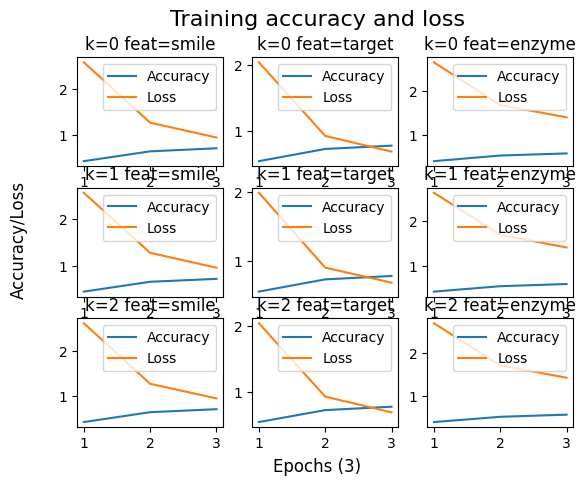

In [17]:
# Classifier to use: DDIMDL, RF, KNN, LR
DDIMDL = 'DDIMDL'
pprint(f'clf model={DDIMDL}')
all_result, each_result = cross_validation(all_matrix, new_label, DDIMDL, event_num, seed, CV,
                                            set_name)
result_all[DDIMDL] = all_result
result_eve[DDIMDL] = each_result

In [18]:
result_all['DDIMDL']

,Accuracy,AUPR_micro,AUPR_macro,AUROC_micro,AUROC_macro,F1_micro,F1_macro,Precision_micro,Precision_macro,Recall_micro,Recall_macro
0,0.771925,0.839645,0.63618,0.994526,0.977938,0.771925,0.350823,0.771925,0.573626,0.771925,0.287847


In [19]:
result_eve['DDIMDL']

,Event#,Accuracy,AUPR,AUROC,F1,Precision,Recall
0,0,0.885412,0.835419,0.903235,0.812143,0.714396,0.940877
1,1,0.901165,0.84131,0.900213,0.822446,0.758424,0.898273
2,2,0.933985,0.792934,0.85009,0.770093,0.815196,0.72972
3,3,0.979498,0.840099,0.886167,0.82954,0.886927,0.779128
4,4,0.98363,0.755926,0.816,0.732221,0.863354,0.635671
...,...,...,...,...,...,...,...
60,60,0.999866,0.500067,0.5,0.0,0.0,0.0
61,61,0.999893,0.600054,0.6,0.333333,1.0,0.2
62,62,0.999866,0.500067,0.5,0.0,0.0,0.0
63,63,0.999866,0.500067,0.5,0.0,0.0,0.0


## Ablation Analysis: Training (RF)

DO NOT RUN FOR GRADING

In [20]:
RF = 'RF'
pprint(f'clf model={RF}')
all_result, each_result = cross_validation(all_matrix, new_label, RF, event_num, seed, CV,
                                            set_name)
result_all[RF] = all_result
result_eve[RF] = each_result

'clf model=RF'
'k-fold k=1'
'feature feat=smile'
'feature feat=target'
'feature feat=enzyme'
'k-fold k=2'
'feature feat=smile'
'feature feat=target'
'feature feat=enzyme'
'k-fold k=3'
'feature feat=smile'
'feature feat=target'
'feature feat=enzyme'


In [21]:
result_all['RF']

,Accuracy,AUPR_micro,AUPR_macro,AUROC_micro,AUROC_macro,F1_micro,F1_macro,Precision_micro,Precision_macro,Recall_micro,Recall_macro
0,0.761137,0.834016,0.634219,0.994702,0.971648,0.761137,0.463387,0.761137,0.714902,0.761137,0.390914


In [22]:
result_eve['RF']

,Event#,Accuracy,AUPR,AUROC,F1,Precision,Recall
0,0,0.890511,0.834925,0.896639,0.81392,0.736464,0.909582
1,1,0.891423,0.828325,0.891598,0.807205,0.737163,0.891955
2,2,0.931301,0.784758,0.847345,0.762259,0.80125,0.726886
3,3,0.976251,0.813489,0.869986,0.801347,0.862736,0.748114
4,4,0.980034,0.696522,0.759425,0.648061,0.854115,0.522104
...,...,...,...,...,...,...,...
60,60,0.999946,0.800027,0.8,0.75,1.0,0.6
61,61,1.0,1.0,1.0,1.0,1.0,1.0
62,62,0.999893,0.600054,0.6,0.333333,1.0,0.2
63,63,0.999866,0.500067,0.5,0.0,0.0,0.0


## Ablation Analysis: Training (GBDT)

DO NOT RUN FOR GRADING

In [ ]:
GBDT = 'GBDT'
pprint(f'clf model={GBDT}')
all_result, each_result = cross_validation(all_matrix, new_label, GBDT, event_num, seed, CV,
                                            set_name)
result_all[GBDT] = all_result
result_eve[GBDT] = each_result

In [ ]:
result_all['GBDT']

In [ ]:
result_eve['GBDT']

## Ablation Analysis: Training (SVM)

DO NOT RUN FOR GRADING

In [ ]:
SVM = 'SVM'
pprint(f'clf model={SVM}')
all_result, each_result = cross_validation(all_matrix, new_label, SVM, event_num, seed, CV,
                                            set_name)
result_all[SVM] = all_result
result_eve[SVM] = each_result

In [ ]:
result_all['SVM']

In [ ]:
result_eve['SVM']

## Ablation Analysis: Training (KNN)

DO NOT RUN FOR GRADING

In [ ]:
KNN = 'KNN'
pprint(f'clf model={KNN}')
all_result, each_result = cross_validation(all_matrix, new_label, KNN, event_num, seed, CV,
                                            set_name)
result_all[KNN] = all_result
result_eve[KNN] = each_result

In [ ]:
result_all['KNN']

In [ ]:
result_eve['KNN']

## Ablation Analysis: Training (LR)

DO NOT RUN FOR GRADING

In [ ]:
LR = 'LR'
pprint(f'clf model={LR}')
all_result, each_result = cross_validation(all_matrix, new_label, LR, event_num, seed, CV,
                                            set_name)
result_all[LR] = all_result
result_eve[LR] = each_result

In [ ]:
result_all['LR']

In [ ]:
result_eve['LR']

## Model Comparison

From the previous result, it shows that with relatively low number of epochs=3, feature_num=3 and kfold=3, we still observe signifant increase of accuracy between DDIMDL model and Random Forest model, accuracy of 0.77 vs. 0.73, 4% difference. I expect the accuracy different will be larger with bigger epoch iterations in DNN.

# Discussion

* In this project, I reproduced the drug-drug interaction events based on the proposed DNN(DDIMDL) model in the paper, with the pre-scraped event dataset from DrugBank.
* What is easy? Since the authors provided the collected data from DrugBank, I did not need to scrape on the DrugBank raw data.
* What is hard? Since the authors used deprecated versions of sklearn, it took me some time to set up the environment correctly with the right python version 3.7.10. But I was able to migrate their code to the latest sklearn as well as making improvement with better dependencies, including the Keras variants of the models, instead of the sklearn models.
* Suggestions: It would be great if the authors could clean up the code and make a finalized jupyter notebook report in ipynb format, clarify on the environment setups. In addition, some components are missing on GitHub from the original paper, including the DeepDDI model implementation, which was supposed to be compared with the proposed DDIMDL model.
* What will you do in next phase: After the project, I would like to going further to explore drug-drug interactions for more than two drugs.


# References

1. Yifan Deng, Xinran Xu, Yang Qiu, Jingbo Xia, Wen Zhang, Shichao Liu, A multimodal deep learning framework for predicting drug–drug interaction events, Bioinformatics, Volume 36, Issue 15, August 2020, Pages 4316–4322, https://doi.org/10.1093/bioinformatics/btaa501

